In [1]:
# Import Library
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

C:\Users\Yasin\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MINST_data/", one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MINST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MINST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MINST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MINST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py fr

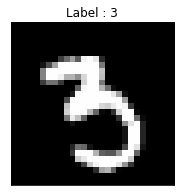

In [3]:
# Check data
train_x, train_y = mnist.train.next_batch(10)
img = train_x[9,:].reshape(28,28)

plt.figure(figsize=(5,3))
plt.imshow(img,'gray')
plt.title("Label : {}".format(np.argmax(train_y[9])))
plt.xticks([])
plt.yticks([])
plt.show()

# Define network

In [4]:
input_h = 28 # Input height
input_w = 28 # Input width
input_ch = 1 # Input channel : Gray scale
# (None, 28, 28, 1)

## First convolution layer
# Filter size
k1_h = 3
k1_w = 3
# the number of channels
k1_ch = 32
# Pooling size
p1_h = 2
p1_w = 2
# (None, 14, 14 ,32)

## Second convolution layer
# Filter size
k2_h = 3
k2_w = 3
# the number of channels
k2_ch = 64
# Pooling size
p2_h = 2
p2_w = 2
# (None, 7, 7 ,64)

## Fully connected
# Flatten the features
# -> (None, 7*7*64)
conv_result_size = int((28/(2*2)) * (28/(2*2)) * k2_ch)
n_hidden1 = 500
n_output = 10

In [5]:
weights = {
    'conv1' : tf.Variable(tf.random_normal([k1_h, k1_w, input_ch, k1_ch],stddev = 0.1)),
    'conv2' : tf.Variable(tf.random_normal([k2_h, k2_w, k1_ch, k2_ch],stddev = 0.1)),
    'hidden1' : tf.Variable(tf.random_normal([conv_result_size, n_hidden1], stddev = 0.1)),
    'output' : tf.Variable(tf.random_normal([n_hidden1, n_output], stddev = 0.1))
}
biases = {
    'conv1' : tf.Variable(tf.random_normal([k1_ch], stddev = 0.1)),
    'conv2' : tf.Variable(tf.random_normal([k2_ch], stddev = 0.1)),
    'hidden1' : tf.Variable(tf.random_normal([n_hidden1], stddev = 0.1)),
    'output' : tf.Variable(tf.random_normal([n_output], stddev = 0.1))
}

In [6]:
# Define Network
def net(x, weights, biases):
    ## First convolution layer
    conv1 = tf.nn.conv2d(x, weights['conv1'], 
                         strides= [1,1,1,1], 
                         padding = 'SAME')
    conv1 = tf.nn.relu(tf.add(conv1, biases['conv1']))
    maxp1 = tf.nn.max_pool(conv1, 
                           ksize = [1, p1_h, p1_w, 1], 
                           strides = [1, p1_h, p1_w, 1], 
                           padding = 'VALID'
                           )
    
    ## Second convolution layer
    conv2 = tf.nn.conv2d(maxp1, weights['conv2'], 
                         strides= [1,1,1,1], 
                         padding = 'SAME')
    conv2 = tf.nn.relu(tf.add(conv2, biases['conv2']))
    maxp2 = tf.nn.max_pool(conv2, 
                           ksize = [1, p2_h, p2_w, 1], 
                           strides = [1, p2_h, p2_w, 1], 
                           padding = 'VALID')

    # shape = conv2.get_shape().as_list()
    # maxp2_re = tf.reshape(conv2, [-1, shape[1]*shape[2]*shape[3]])
    maxp2_re = tf.reshape(maxp2, [-1, conv_result_size])
    
    ### Fully connected
    hidden1 = tf.add(tf.matmul(maxp2_re, weights['hidden1']), biases['hidden1'])
    hidden1 = tf.nn.relu(hidden1)
    output = tf.add(tf.matmul(hidden1, weights['output']), biases['output'])
    return output

In [7]:
LR = 0.0001
x = tf.placeholder(tf.float32, [None, input_h, input_w, input_ch])
y = tf.placeholder(tf.float32, [None, n_output])

pred = net(x, weights, biases)
loss = tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=pred)
loss = tf.reduce_mean(loss)

# optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)
optm = tf.train.AdamOptimizer(LR).minimize(loss)

init = tf.global_variables_initializer()

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



# Traning step

In [8]:
n_batch = 50
n_iter = 2500
n_prt = 250

In [9]:
# Run initialize
config = tf.ConfigProto(allow_soft_placement=True)  # GPU Allocating policy
sess = tf.Session(config=config)
sess.run(init)

# Training cycle
for epoch in range(n_iter):
    train_x, train_y = mnist.train.next_batch(n_batch)
    train_x = np.reshape(train_x, [-1, input_h, input_w, input_ch])
    sess.run(optm, feed_dict={x: train_x,  y: train_y})
    
    if epoch % n_prt == 0:
        c = sess.run(loss, feed_dict={x: train_x,  y: train_y})
        print ("Iter : {}".format(epoch))
        print ("Cost : {}".format(c))

Iter : 0
Cost : 3.307934284210205
Iter : 250
Cost : 0.2329138219356537
Iter : 500
Cost : 0.11075463145971298
Iter : 750
Cost : 0.4213970899581909
Iter : 1000
Cost : 0.15152835845947266
Iter : 1250
Cost : 0.0238655973225832
Iter : 1500
Cost : 0.09274615347385406
Iter : 1750
Cost : 0.04116148501634598
Iter : 2000
Cost : 0.021071748808026314
Iter : 2250
Cost : 0.07239507883787155


# Testing step

In [10]:
test_x, test_y = mnist.test.next_batch(100)

my_pred = sess.run(pred, feed_dict={x : test_x.reshape(-1, 28, 28, 1)})
my_pred = np.argmax(my_pred, axis=1)

labels = np.argmax(test_y, axis=1)

accr = np.mean(np.equal(my_pred, labels))
print("Accuracy : {}%".format(accr*100))

Accuracy : 100.0%


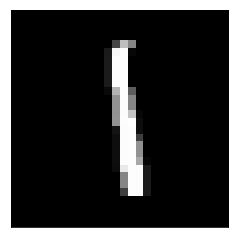

Prediction : 1
Probability : [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


In [11]:
test_x, test_y = mnist.test.next_batch(1)
logits = sess.run(tf.nn.softmax(pred), feed_dict={x : test_x.reshape(-1, 28, 28, 1)})
predict = np.argmax(logits)

plt.imshow(test_x.reshape(28,28), 'gray')
plt.xticks([])
plt.yticks([])
plt.show()

print('Prediction : {}'.format(predict))
np.set_printoptions(precision=2, suppress=True)
print('Probability : {}'.format(logits.ravel()))